<a href="https://colab.research.google.com/github/Shreyanshi200/Image-Steganography-using-CNN/blob/main/Deep_Steganography_Batch19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Steganography

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
BATCH_SIZE = 12
EPOCHS = 5
LEARNING_RATE = 1e-3

In [ ]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Defining layers

In [ ]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, n_layers, filters=50, kernel_size=(3, 3), activation=tf.nn.relu, **kwargs):
        super().__init__(**kwargs)
        self.convs = []
        for conv in range(n_layers):
            self.convs.append(
                tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
            )

    def call(self, input_tensor, training=False):
        x = self.convs[0](input_tensor, training=training)
        for i in range(1, len(self.convs)):
            x = self.convs[i](x, training=training)

        return x

In [ ]:
class PrepLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

    def call(self, input_tensor, training=False):
        prep_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor.shape)(input_tensor)
        conv_4_3x3 = self.conv_layer_4_3x3(prep_input, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(prep_input, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(prep_input, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        return self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

In [ ]:
class HideLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_3 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):
        prep_input = input_tensor[0]
        hide_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor[1].shape)(input_tensor[1])
        concat_1 = self.concat_1([prep_input, hide_input])

        conv_4_3x3 = self.conv_layer_4_3x3(concat_1, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(concat_1, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(concat_1, training=training)

        concat_2 = self.concat_2([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_2)
        conv_1_4x4 =  self.conv_1_4x4(concat_2)
        conv_1_5x5 =  self.conv_1_5x5(concat_2)

        concat_3 = self.concat_3([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_3)


In [ ]:
class RevealLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):

        conv_4_3x3 = self.conv_layer_4_3x3(input_tensor, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(input_tensor, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(input_tensor, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        concat_2 = self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_2)

In [ ]:
class MyModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.hide_layer = HideLayer()
        self.reveal_layer = RevealLayer()

    def call(self, input_tensor, training=False):
        secret = input_tensor[0]
        cover = input_tensor[1]
        prep_output = self.prep_layer(secret)
        hide_output = self.hide_layer([prep_output, cover])
        reveal_output = self.reveal_layer(hide_output)

        return  reveal_output, hide_output

    def model(self, inputs):
        return tf.keras.Model(inputs=inputs, outputs=self.call(inputs))

### Defining Loss Function

In [ ]:
class StenographyLoss(tf.keras.losses.Loss):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, y_true, y_pred):
        beta = tf.constant(self.beta, name='beta')

        secret_true = y_true[0]
        secret_pred = y_pred[0]

        cover_true = y_true[1]
        cover_pred = y_pred[1]

        secret_mse = tf.losses.MSE(secret_true, secret_pred)
        cover_mse = tf.losses.MSE(cover_true, cover_pred)

        return tf.reduce_mean(cover_mse + beta * secret_mse)

In [ ]:
secret_input = tf.keras.layers.Input(shape=(64, 64, 3), name='secret_input')
cover_input = tf.keras.layers.Input(shape=(64, 64, 3), name='cover_input')

model = MyModel().model(inputs=[secret_input, cover_input])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 secret_input (InputLayer)   [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 prep_layer (PrepLayer)      (None, 64, 64, 150)          758250    ['secret_input[0][0]']        
                                                                                                  
 cover_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 hide_layer (HideLayer)      (None, 64, 64, 3)            1133703   ['prep_layer[0][0]',          
                                                                     'cover_input[0][0]']     

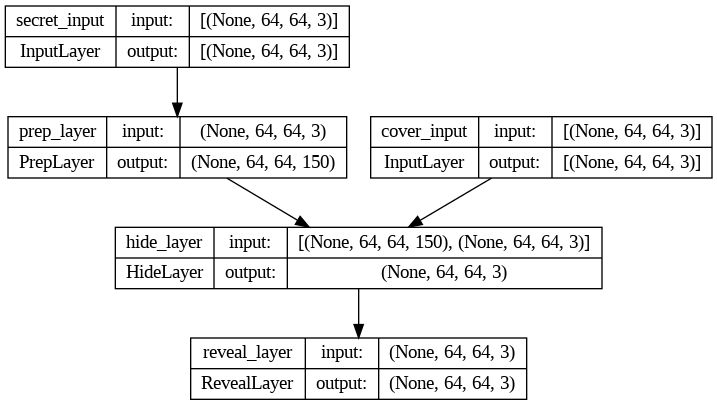

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [ ]:
optmizer = tf.optimizers.Adam(LEARNING_RATE)
stenography_loss = StenographyLoss(beta=1.0)

model.compile(
    optimizer=optmizer,
    loss=stenography_loss,
    metrics =['accuracy']
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

### Loading Tiny ImageNet data

In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("Maysee/tiny-imagenet")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from sklearn.model_selection import train_test_split

train_data, _ = train_test_split(dataset['train']['image'], train_size=.15) # Getting a subset of the Tiny ImageNet dataset.

X_train, X_test = train_test_split(train_data, test_size=.1)
X_train_secret, X_train_cover = train_test_split(X_train, test_size=.5)
X_test_secret, X_test_cover = train_test_split(X_test, test_size=.5)
X_val_secret, X_val_cover = train_test_split(dataset['valid']['image'], test_size=.5)

del X_train
del X_test
del train_data

### Data visualization

In [ ]:
import matplotlib.pyplot as plt

def show_image(arr):
    plt.imshow(np.array(arr, np.int32))
    return plt

In [ ]:
show_image(X_train_cover[0]).show()

### Data preparation

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, secret, cover, batch_size, shuffle=True):
        self.secret = secret
        self.cover = cover
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.datalen = len(secret)
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index: int):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        secret_batch = np.array(self.secret)[batch_indexes]
        cover_batch = np.array(self.cover)[batch_indexes]

        return [secret_batch, cover_batch], [secret_batch, cover_batch]

    def __len__(self):
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
for i in range(len(X_train_secret)):
    X_train_secret[i] = tf.keras.utils.img_to_array(X_train_secret[i].convert('RGB'))
    X_train_cover[i] = tf.keras.utils.img_to_array(X_train_cover[i].convert('RGB'))

for i in range(len(X_test_secret)):
    X_test_secret[i] = tf.keras.utils.img_to_array(X_test_secret[i].convert('RGB'))
    X_test_cover[i] = tf.keras.utils.img_to_array(X_test_cover[i].convert('RGB'))

for i in range(len(X_val_secret)):
    X_val_secret[i] = tf.keras.utils.img_to_array(X_val_secret[i].convert('RGB'))
    X_val_cover[i] = tf.keras.utils.img_to_array(X_val_cover[i].convert('RGB'))

In [ ]:
train_gen = DataGenerator(X_train_secret, X_train_cover, BATCH_SIZE)
test_gen = DataGenerator(X_test_secret, X_test_cover, BATCH_SIZE, shuffle=False)
val_gen = DataGenerator(X_val_secret, X_val_cover, BATCH_SIZE, shuffle=False)

### Training model

In [ ]:
!pip install tensorboard
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=1,
    shuffle=True,
    callbacks=callbacks
)

%load_ext tensorboard
%tensorboard --logdir ./logs

### Testing model

In [ ]:
pred = model.predict(test_gen)

In [ ]:
show_image(X_test_secret[0])  # Secret

In [ ]:
show_image(pred[0][0])  # Revealed

In [ ]:
show_image(X_test_cover[0])  # Cover

In [ ]:
show_image(pred[1][0])  # Cover with secret

### Saving complete model

In [ ]:
model.save("./models/complete_model.h5", include_optimizer=False)